In [13]:
# pip install dwave-ocean-sdk

import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from dwave.samplers import *

solvers = {'Simulated Annealing': SimulatedAnnealingSampler(),
            'Steepest Descent': SteepestDescentSolver(),
            'Tabu Search': TabuSampler(),
            #'Tree Decomposition': TreeDecompositionSolver(),               # Caps at low tree width
            # 'Tree Decomposition Sampler': TreeDecompositionSampler(),      # SLOW
            'Random Sampler': RandomSampler()}

# Seed the random for point construction.
np.random.seed(42)
# Simulation count
sim_count = 100
# Control size of the clusters
variables = 200 

In [14]:
# Objective function
def generate_qubo_parameters(D):
    n = len(D)
    Q = {}
    for i, j in product(range(n), repeat=2):
        if i != j:
            # Calculate Euclidean distance between points i and j.
            Q[(i, j)] = np.linalg.norm(D[i] - D[j])
        else:
            # Penalty term, simply the distance to all other points (and tehcnically itself).
            Q[(i, j)] = -sum(np.linalg.norm(D[k] -D[i]) for k in range(n))
    return Q

# Two clusters with centers at [1, 1] and [5, 5], combine them.
D = np.concatenate((np.random.normal(loc=[1, 1], scale=1, size=(variables, 2)), np.random.normal(loc=[5, 5], scale=1, 
                    size=(variables, 2))))

# Construct the cost function.
Q = generate_qubo_parameters(D)

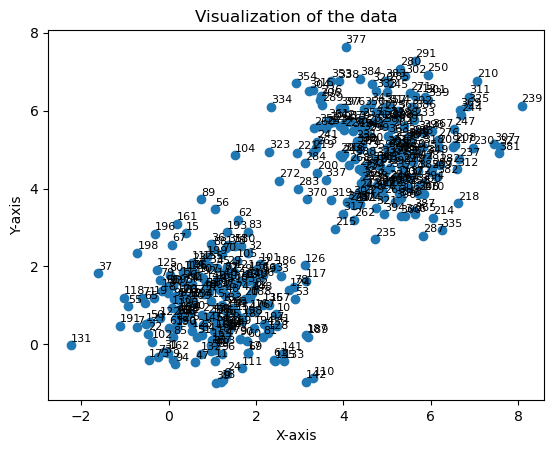

In [15]:
# Draw a scatter plot of the initial data.
def plotter(D):
    # Create a scatter plot, add labels to points.
    plt.scatter(*zip(*D)), [plt.text(x, y + 0.1, str(i), fontsize=8) for i, (x, y) in enumerate(D)]
    # Add axis labels and a legend, show.
    plt.xlabel('X-axis'), plt.ylabel('Y-axis'), plt.title('Visualization of the data'), plt.show()

plotter(D)

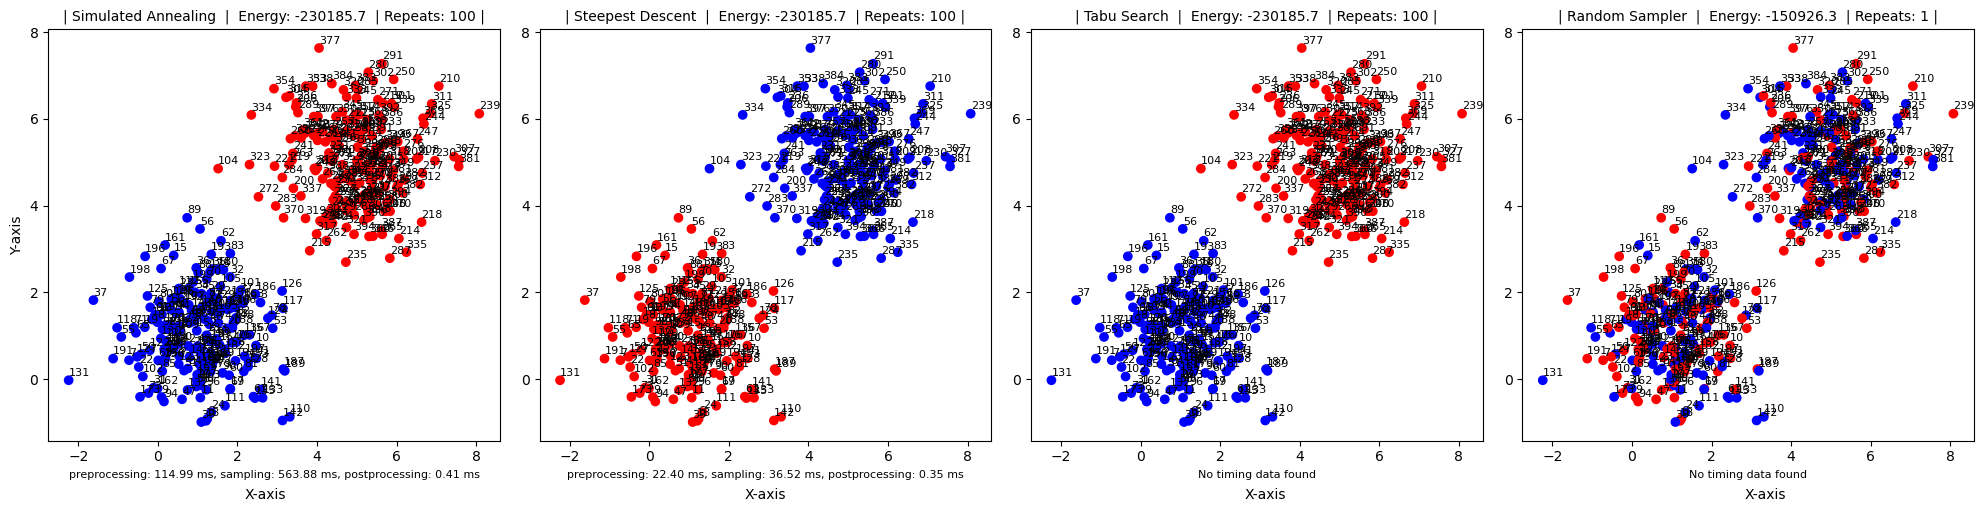

In [50]:
def draw_result(ax, D, sample, title, runtime):
    # Iterate over the samples in the sampleset. Iteration "useless" currently.
    for record in sample.record:
        # Create a scatter plot with different colors based on cluster assignment.
        ax.scatter(D[:, 0], D[:, 1], c=sample.record['sample'], cmap='bwr')
        # Plot point number labels.
        [ax.text(x, y + 0.1, str(i), fontsize=8) for i, (x, y) in enumerate(D)]
        # Add labels.
        ax.set_xlabel('{}'.format(runtime), fontsize=8), ax.set_title("| {}  |  Energy: {}  | Repeats: {} |".format(title, 
                        round(record['energy'], 1), record['num_occurrences']), loc='center', fontsize=10)
        
def index_axs(axs, index):
    try:
        # Attempt to check if axs is 2D (e.g., a 2D numpy array or a list of lists)
        if hasattr(axs, 'ndim') and axs.ndim == 2:
            # Use 2D indexing
            return axs[index // 4, index % 4]
        else:
            # Assume axs is 1D if no explicit 2D structure is detected
            return axs[index]
    except AttributeError:
        # Fallback if axs does not have the 'ndim' attribute or similar
        # This assumes axs is 1D if 'ndim' or equivalent isn't present
        return axs[index]

# Count the solvers
num_plots = len(solvers)
# Determine the number of rows and columns required for the solver count.
num_rows = (num_plots + 3) // 4
num_cols = min(num_plots, 4)
# Create figures.
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))

# iterate over solvers
for index, (key, value) in enumerate(solvers.items()):
    # Sample given solver, with sim_count repeats.
    sample = value.sample_qubo(Q, num_reads=sim_count)
    # Combine the results that are equal, get the lowest results.
    sample_2 = sample.aggregate().lowest()
    # If there are two lowest energy states, with symmetric but opposite categorization, 
    # we sum the count together and display only one.
    if len(sample_2) > 1:
        # Testing if the bit assignment is flipped.
        if all(sample_2.record[0][0] == [1 if bit == 0 else 0 for bit in sample_2.record[1][0]]):
            # Count the sum of the two equivalent states found.
            count = sum(sample_2.record['num_occurrences'])
            # Remove the other state
            sample_2 = sample_2.slice(-len(sample_2) + 1)
            # Set the total num_occurrences of the found state as the total count of both.
            sample_2.record[0]['num_occurrences'] = count

        # If somehow we find multiple non-equivalent states, we print a warning and break out.
        else:
            print("Found {} states that are not mirrored!".format(len(sample_2)))
            break
    
    # Try finding the timing data if the solver/sampler carries this info.
    time_data = "No timing data found"
    if "timing" in sample.info:
        # Formatting the output.
        timing_ms = {key.split('_')[0]: value / 1_000_000 for key, value in sample.info["timing"].items()}
        # Create a string representation of the data.
        time_data = ', '.join(f'{key}: {value:.2f} ms' for key, value in timing_ms.items())

    # Draw the resulting plot of the solver.
    draw_result(index_axs(axs, index), D, sample_2, key, time_data)

# X-axis labels
for x in range(0, num_cols):
    fig.text(0.125 + 0.25*x, 0, 'X-axis', va='center')

# Axis labels
for row in range(0, num_rows):
    if (num_rows > 1):
        axs[row, 0].set_ylabel('Y-axis')
    else:
        axs[row].set_ylabel('Y-axis')
    
plt.tight_layout()
plt.show()
